# issues

In [10]:
import numpy as np
import pandas as pd

from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import dextra.dna.core as C
import dextra.dna.commons as P

In [12]:
spark = P.config.spark

pd.set_option('display.max_colwidth', 200)

sns.set()

## Reading Trusted Dataset

In [13]:
DATA_FILE = P.config.lakes.refined + '/issues.parquet'

In [14]:
x = C.io.stream.read(DATA_FILE)

x.limit(5).toPandas()

,complaint_id,consumer_message,customer_name,date_received,disputed,issue,product,resolution,state,sub_issue,sub_product,tags,timely_response,via,zip_code,ingested_at
0,fbf77b8d5880,3463 Averst Bank 2008 this is to old to be on my credit repot. Its 4985. I want this removed. I gave this back to then. They sold me a lemon. The transmission had went out of this thing after a 44...,ecbc39add660,2017-01-16,False,Cont'd attempts collect debt not owed,Debt collection,Closed with explanation,960999033556,Debt was paid,Auto,None,True,Web,73123,2020-12-03 20:01:53.662609
1,fbf7e0affa38,"My loan was sold to Nationstar. At the time there was a {$1400.00} escrow surplus. However after one month, NS sent a letter stating that an audit revealed I had a shortage of {$500.00} and my pym...",dd0bf53c5982,2015-09-02,True,"Loan servicing, payments, escrow account",Mortgage,Closed with explanation,577ce5eff01b,None,Conventional fixed mortgage,None,True,Web,91113,2020-12-03 20:01:53.662609
2,fbf7fda793c5,Dear Sir or Madam : I am writing to file a complaint against USAA following their handling of a dispute of a billing error in the amount of {$1300.00} 0662 on my USAA {phone} account. The amount i...,8c6ba4882fdb,2015-09-09,False,Billing disputes,Credit card,Closed with explanation,86266b7866cc,None,None,Servicemember,True,Web,10064,2020-12-03 20:01:53.662609
3,fbf80c5bdf5f,"PLEASE FIND ATTACHED LETTER I WROTE TO THE MORTGAGE COMPANY THAT I USED TO BE WITH AND PAY PAYMENTS. THEY ARE REPORTING LATE PAYMENT, I WAS 8556 TO 6951 BACK THEN AND MY PARENTS MADE A MISTAKE AN...",9d59e25a9a81,2017-08-30,None,Incorrect information on your report,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,577ce5eff01b,Account status incorrect,Credit reporting,Servicemember,True,Web,91687,2020-12-03 20:01:53.662609
4,fbf897be7d3d,Merchants Credit continues to report 8030 paid medical accounts that were the result of a billing error despite my written letters and being notified in writing by original creditor ( 9160 97...,ba5bdf5ece97,2017-05-22,None,Attempts to collect debt not owed,Debt collection,Untimely response,b621dda48fda,Debt was paid,Medical debt,None,False,Web,98095,2020-12-03 20:01:53.662609


## Issues

In [15]:
issues_s = (
    x.groupBy('issue')
     .count()
     .orderBy(F.desc('count'))
     .limit(10)
     .toPandas())

issues_s

,issue,count
0,Incorrect information on credit report,21220
1,Cont'd attempts collect debt not owed,17447
2,"Loan servicing, payments, escrow account",14727
3,"Loan modification,collection,foreclosure",10791
4,Dealing with my lender or servicer,7910
5,Disclosure verification of debt,7595
6,Incorrect information on your report,7373
7,Communication tactics,6651
8,"Account opening, closing, or management",6348
9,Credit reporting company's investigation,5663


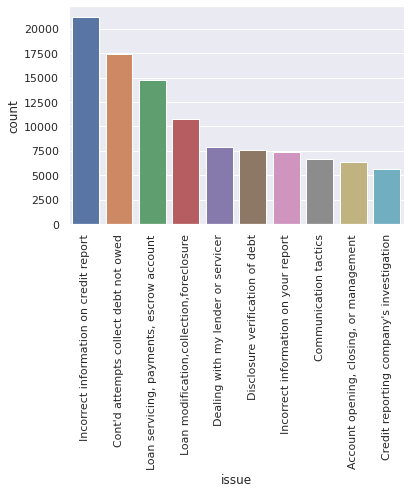

In [16]:
sns.barplot(data=issues_s, x='issue', y='count')
plt.xticks(rotation=90);

### Complaints per User

In [17]:
print('users with a single complaint:')
complaints_per_client_s = (
    x.groupBy('customer_name')
     .count()
     .sample(True, 0.1, seed=519753)
     .toPandas())

complaints_per_client_s.describe().T

users with a single complaint:


,count,mean,std,min,25%,50%,75%,max
count,11793.0,1.683032,2.239274,1.0,1.0,1.0,2.0,111.0


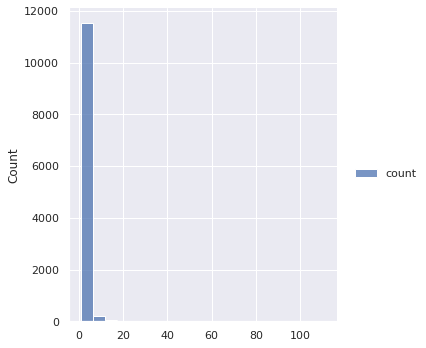

In [18]:
sns.displot(complaints_per_client_s, bins=20);

### Dates in Which Complaints Occurred

In [19]:
receiving_dates_s = (
    x.select('date_received')
     .sample(True, 0.1, seed=519753)
     .toPandas())

receiving_dates_s.describe().T

,count,unique,top,freq
date_received,19937,919,2017-01-19,108


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


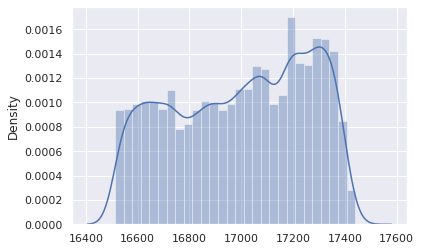

In [20]:
sns.distplot(receiving_dates_s.values.astype('datetime64'));

### Location

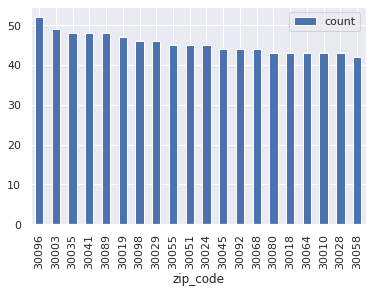

In [21]:
(x.where(x.zip_code.isNotNull())
  .groupBy('zip_code')
  .count()
  .orderBy(F.desc('count'))
  .limit(20)
  .toPandas()
  .set_index('zip_code')
  .plot(kind='bar'));